## 0) Load pdfplumber and pandas

In [1]:
import pdfplumber
import pandas as pd

## 1) Load the PDF into pdfplumber

In [2]:
pdf = pdfplumber.open("RBWO_FY2014_Provider_Profile_Guide.pdf")

## 2) Select the 10th page of the PDF, the first with a profile on it

In [3]:
page = pdf.pages[9]

## 3) Use `page.to_image()` to verify we got the correct page

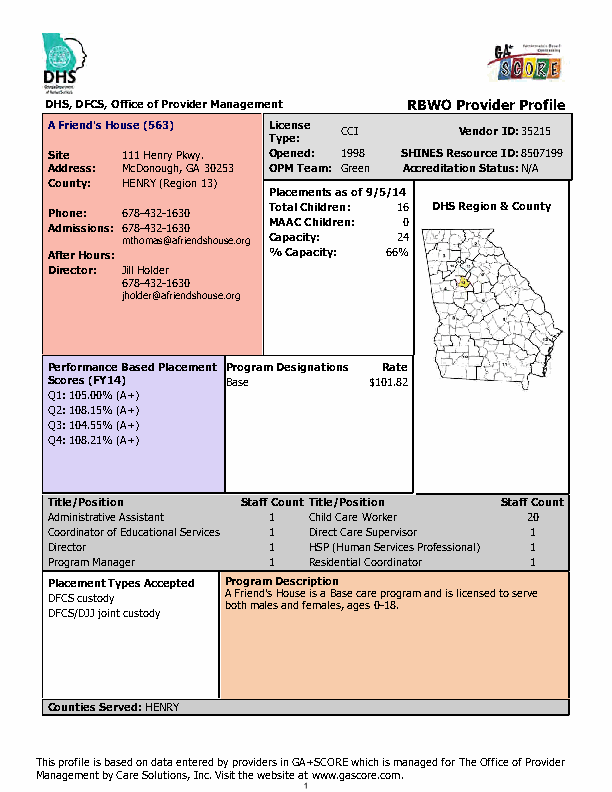

In [4]:
im = page.to_image()
im

## 4) Define a function, `is_profile_page(page)`, that will return `True` if a page looks like the one above, but `False` if not

There are many approaches that could work. How about a simple one that looks for "SHINES Resource ID:" in the text?

In [5]:
def is_profile_page(page):
    return "SHINES Resource ID:" in page.extract_text()


## 5) Convince yourself it worked 

... by running `is_profile_page(...)` on at least a few pages for which you expect it to return `True` and few for which you expect it to return `False`

In [6]:
is_profile_page(pdf.pages[0])

False

In [7]:
is_profile_page(pdf.pages[9])

True

In [8]:
is_profile_page(pdf.pages[10])

False

In [9]:
is_profile_page(pdf.pages[11])

True

## 6) For the 10th page, extract the provider name

You could do this in a few ways. One approach could be to use `page.filter(...)` to grab just the text with that particular `non_stroking_color`. To figure out that color, you'll want to see all the `non_stroking_color`s of all the characters on the page.

In [10]:
(
    pd.DataFrame(page.chars)
    ["non_stroking_color"]
    .value_counts()
)

non_stroking_color
(0, 0, 0)      1233
(0, 0, 0.4)      22
(0,)              1
Name: count, dtype: int64

In [11]:
def is_provider_color(obj):
    return obj.get("non_stroking_color") == (0, 0, 0.4)

In [12]:
page.filter(is_provider_color).extract_text()

"A Friend's House (563)"

## 7) For the 10th page, extract the quarterly performance scores

There are many ways you could do this, but it's probably sufficient to use a regular expression.

In [13]:
score_pattern = r"Q(\d): ([\d\.]+)%"
score_matches = page.search(score_pattern)
for match in score_matches:
    print(match["groups"])

('1', '105.00')
('2', '108.15')
('3', '104.55')
('4', '108.21')


## 8) Put it all all together

Create a DataFrame, with one row per score, with the following columns:

- Provider name/ID
- Quarter
- Score

You can skip/ignore scores listed as "N/A".

To do this, you'll want to:

1. Loop across every page
2. If it tests true for `is_profile_page(...)` ...
3. ... then extract the name and loop through the scores

Note: Looping through all 528 pages of the PDF might take a couple of minutes.

In [14]:
import re

def get_provider_name(page):
    raw = page.filter(is_provider_color).extract_text()
    return re.sub(r"\s+", " ", raw)

In [15]:
entries = []
for page in pdf.pages:
    if is_profile_page(page):
        provider = get_provider_name(page)
        for score in page.search(score_pattern):
            entries.append({
                "provider": provider,
                "quarter": int(score["groups"][0]),
                "score": float(score["groups"][1]),
            })
            
entries_df = pd.DataFrame(entries)
entries_df.head()

,provider,quarter,score
0,A Friend's House (563),1,105.00
1,A Friend's House (563),2,108.15
2,A Friend's House (563),3,104.55
3,A Friend's House (563),4,108.21
4,Advocates for Bartow's Children Flowering Bran...,1,96.59


## 9) Which providers had the lowest single-quarter score?

In [16]:
entries_df.nsmallest(1, "score", keep="all")

,provider,quarter,score
176,"ENA, Inc., dba NECCO (formerly GA SAFE) Albany...",4,0.0
680,"CHRIS Kids, Inc. DBA: Gateway Foster Care (5166)",2,0.0
681,"CHRIS Kids, Inc. DBA: Gateway Foster Care (5166)",3,0.0


---

---

---